In [1]:
root_dir = '/home2/glee/dissertation/1_tech_gen_impact/master/Tech_Gen/'
import sys
sys.path.append(root_dir)

import copy
import gc
import os
import argparse
import math
import time
import pickle
import re
import multiprocess as mp
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
sys.path.append("/share/tml_package")
from tml import utils
from scipy import io
from tqdm import tqdm
from collections import OrderedDict

import torch
from torch.nn import functional as F
from torch.nn import DataParallel as DP
from torch.utils.data import TensorDataset, DataLoader, Subset, Dataset
from accelerate import Accelerator
import pytorch_model_summary

import optuna
from optuna.samplers import RandomSampler, TPESampler
from optuna.integration import SkoptSampler

import numpy as np
import pandas as pd
import scipy.stats
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import matthews_corrcoef, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from data import TechDataset, CVSampler
from models import Transformer, Predictor
from train_utils import EarlyStopping, perf_eval, objective_cv, build_model, train_model, validate_model_mp
from utils import token2class, DotDict, to_device

from cleantext.sklearn import CleanTransformer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# PART 1: Configuration

In [2]:
args = argparse.Namespace(
    data_type="claim",
    data_file = "collection_[H01L,H10][2017].csv",
    target_ipc="H01L",
    pred_type="classification",
    n_TC = 5,
    use_pretrained_tokenizer=False,
    do_train=None,
    do_tune=None,
    n_folds=None,
    max_epochs=50,
    use_accelerator=None,
    do_save=False,
    n_gpus=3,
    light=True,
    config_file=os.path.join(root_dir, "configs", "USED_configs", "[CONFIGS]2023-04-11_00:39.json"),
    eval_train_set=False)

data_dir = os.path.join(root_dir, "data")
model_dir = os.path.join(root_dir, "models")
result_dir = os.path.join(root_dir, "results")
config_dir = os.path.join(root_dir, "configs")

if args.config_file is not None:
    config_file = args.config_file
else:
    config_file = os.path.join(config_dir, "configs_light.json") if args.light else os.path.join(config_dir, "configs.json")
configs = DotDict().load(config_file)
org_config_keys = {key: list(configs[key].keys()) for key in configs.keys()}

instant_configs = {key: value for (key, value) in vars(args).items() if value is not None} # if any argument passed when main.py executed
instant_configs_for_update = {configkey: {key: value for (key,value) in instant_configs.items() if key in org_config_keys[configkey]} for configkey in org_config_keys.keys()}
for key, value in configs.items():
    value.update(instant_configs_for_update[key])

regex_ipc = re.compile('[A-Z](?![\\D])')
if regex_ipc.match(configs.data.target_ipc) is None:
    configs.data.update({"target_ipc": "ALL"})
elif len(configs.data.target_ipc) > 5:
    configs.data.update({"target_ipc": configs.data.target_ipc[:4]})

if configs.model.model_type == "enc-pred-dec":
    configs.train.loss_weights["recon"] = configs.train.loss_weights["recon"] / sum(configs.train.loss_weights.values())
    configs.train.loss_weights["y"] = 1 - configs.train.loss_weights["recon"]
elif configs.model.model_type == "enc-pred":
    configs.train.loss_weights = {"recon": 0, "y": 1}
elif configs.model.model_type == "enc-dec":
    configs.train.loss_weights = {"recon": 1, "y": 0}

if configs.train.use_accelerator:
    accelerator = Accelerator()
    device_ids = list(range(torch.cuda.device_count()))
    device = accelerator.device

    configs.train.update({"accelerator": accelerator})
else:
    if torch.cuda.is_available():
        device_ids = list(range(torch.cuda.device_count()))
        gpu_usages = [np.sum([float(usage.split("uses")[-1].replace(" ","").replace("MB","")) for usage in torch.cuda.list_gpu_processes(id).split("GPU memory") if not usage=="" and "no processes are running" not in usage]) for id in device_ids]
        device_ids = np.argsort(gpu_usages)[:configs.train.n_gpus]
        device_ids = list(map(lambda x: torch.device('cuda', x),list(device_ids)))
        device = device_ids[0] # main device
        torch.cuda.set_device(device)
    else:
        device = torch.device('cpu')
        device_ids = []

configs.data.update({"root_dir": root_dir,
                        "data_dir": data_dir,
                        "model_dir": model_dir,
                        "result_dir": result_dir})
configs.train.update({"device": device,
                        "device_ids": device_ids,
                        "root_dir": root_dir,
                        "data_dir": data_dir,
                        "model_dir": model_dir,
                        "use_keywords": configs.data.use_keywords,
                        "early_stop_patience": int(0.3*configs.train.max_epochs)})
configs.model.update({"device": device,
                        "device_ids": device_ids,
                        "n_directions": 2 if configs.model.bidirec else 1,
                        "use_accelerator": configs.train.use_accelerator})

## Set hyperparameters for model training (To be TUNED)
if configs.train.do_train and configs.train.do_tune:
    n_layers = configs.model.n_layers = None
    d_embedding = configs.model.d_embedding = None
    d_hidden = configs.model.d_hidden = None
    d_latent = None
    learning_rate = configs.train.learning_rate = None
    batch_size = configs.train.batch_size = None
    config_name = "HPARAM_TUNING"
    final_model_path = None
else:
    n_layers = configs.model.n_layers
    d_embedding = configs.model.d_embedding
    d_hidden = configs.model.d_hidden
    d_latent = configs.model.n_enc_seq * configs.model.d_hidden

    key_components = {"data": ["target_ipc", "pred_type", "max_seq_len", "vocab_size"], "model": ["n_layers", "d_hidden", "d_embedding", "d_ff", "n_head", "d_head", "take_last_h"], "train": ["learning_rate", "batch_size", "max_epochs"]}
    config_name = ""
    for key in key_components.keys():
        for component in key_components[key]:
            config_name += "["+str(configs[key][component])+component+"]"
    final_model_path = os.path.join(model_dir, f"[Final_model]{config_name}.ckpt")

configs.model.update({"d_latent": d_latent})
configs.train.update({"config_name": config_name,
                        "final_model_path": final_model_path})


# PART 2: Dataset setting

In [3]:
tstart = time.time()
org_config_keys_temp = copy.copy(org_config_keys["data"])
org_config_keys_temp.pop(org_config_keys_temp.index("use_pretrained_tokenizer"))
org_config_keys_temp.pop(org_config_keys_temp.index("data_file"))
dataset_config_name = "-".join([str(key)+"="+str(value) for (key,value) in configs.data.items() if key in org_config_keys_temp])
dataset_path = os.path.join(data_dir, "pickled_dataset", "[tech_dataset]"+dataset_config_name+".pickle")
if os.path.exists(dataset_path) and args.do_save is False:
    print("Load pickled dataset...")
    with open(dataset_path, "rb") as f:
        tech_dataset = pickle.load(f)   # Load pickled dataset if dataset with same configuration already saved
    print("Pickled dataset loaded")
else:
    print("Make dataset...")
    tech_dataset = TechDataset(configs.data)
    with open(dataset_path, "wb") as f:
        tech_dataset.rawdata = None
        pickle.dump(tech_dataset, f)
tend = time.time()
print(f"{np.round(tend-tstart,4)} sec elapsed for loading patents for class [{configs.data.target_ipc}]")

configs.model.update({"tokenizer": tech_dataset.tokenizer,
                        "n_enc_vocab": tech_dataset.tokenizer.get_vocab_size(),
                        "n_dec_vocab": tech_dataset.tokenizer.get_vocab_size(),
                        "n_enc_seq": tech_dataset.max_seq_len,
                        "n_dec_seq": tech_dataset.max_seq_len,
                        "n_outputs": 1 if configs.data.pred_type=="regression" else tech_dataset.n_outputs,
                        "i_padding": tech_dataset.tokenizer.token_to_id("<PAD>")})
configs.model.update({"d_latent": configs.model.n_enc_seq * configs.model.d_hidden})

Load pickled dataset...
Pickled dataset loaded
0.2436 sec elapsed for loading patents for class [H01L]


## Inference

In [4]:
final_model = build_model(configs.model, tokenizer=tech_dataset.tokenizer)
if os.path.exists(final_model_path):
    best_states = torch.load(final_model_path)
else:
    raise Exception("Model need to be trained first")
converted_states = OrderedDict()
for k, v in best_states.items():
    if 'module' not in k:
        k = 'module.'+k
    else:
        k = k.replace('features.module.', 'module.features.')
    converted_states[k] = v
final_model.load_state_dict(converted_states)

<All keys matched successfully>

In [5]:
# Copy predictor
temp_path = os.path.join(model_dir, "temp", "temp.ckpt")
predictor = Predictor(final_model.module.config).to(final_model.module.device)
torch.save(final_model.module.predictor.state_dict(), temp_path)
predictor.load_state_dict(torch.load(temp_path, map_location=final_model.module.device))

<All keys matched successfully>

In [6]:
result_path = os.path.join(root_dir, "results")

In [7]:
used_train_data = pd.read_excel(os.path.join(result_path, "[DATASET]2023-04-11_00:39.xlsx"), sheet_name="TRAIN_dataset")
used_test_data = pd.read_excel(os.path.join(result_path, "[DATASET]2023-04-11_00:39.xlsx"), sheet_name="TEST_dataset")
used_train_index = tech_dataset.data.index.get_indexer(pd.Index(used_train_data["number"]))
used_test_index = tech_dataset.data.index.get_indexer(pd.Index(used_test_data["number"]))

In [9]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [10]:
batch_size = 128

In [11]:
used_train_dataset = Subset(tech_dataset, used_train_index)
train_loader = DataLoader(used_train_dataset, batch_size=batch_size, drop_last=True)

In [12]:
zs, ys, preds = [], [], []
newzs = []
for batch in tqdm(train_loader):
    x = to_device(batch["text_inputs"], final_model.module.device)
    y = batch["targets"]
    
    enc_outputs = final_model.module.encode(x)
    pred_outputs = final_model.module.predictor(enc_outputs)
    z = enc_outputs.view(batch_size, -1).cpu().detach().numpy()
    torch.cuda.empty_cache()
    pred = pred_outputs.cpu().detach().numpy()

    zs.append(z)
    ys.append(y)
    preds.append(pred.argmax(1))
#     newzs.append(newz)
    
    torch.cuda.empty_cache()
                                                
zs = np.concatenate(zs)
ys = np.concatenate(ys)
preds = np.concatenate(preds)
# newzs = np.concatenate(newzs)

100%|██████████| 249/249 [00:36<00:00,  6.91it/s]


In [226]:
## TRAIN set
idx = 99

input_claims = tech_dataset.X[used_train_index][idx]
text_inputs = tech_dataset.tokenizer.encode(input_claims)
batch_input = {"input_ids": torch.tensor([tech_dataset.tokenizer.encode(input_claims).ids]), "attention_mask": torch.tensor(tech_dataset.tokenizer.encode(input_claims).attention_mask)}
input_inf = to_device(batch_input, final_model.module.device)

output_claims = tech_dataset.X[used_train_index][idx]
text_outputs = tech_dataset.tokenizer.encode(output_claims)
batch_output = {"input_ids": torch.tensor([tech_dataset.tokenizer.encode(output_claims).ids]), "attention_mask": torch.tensor(tech_dataset.tokenizer.encode(output_claims).attention_mask)}
output_inf = to_device(batch_output, final_model.module.device)

In [258]:
## TEST set
idx = np.random.choice(np.where(tech_dataset.Y[used_test_index].values==0)[0])
print(idx)

input_claims = tech_dataset.X[used_test_index][idx]
text_inputs = tech_dataset.tokenizer.encode(input_claims)
batch_input = {"input_ids": torch.tensor([tech_dataset.tokenizer.encode(input_claims).ids]), "attention_mask": torch.tensor(tech_dataset.tokenizer.encode(input_claims).attention_mask)}
input_inf = to_device(batch_input, final_model.module.device)

output_claims = tech_dataset.X[used_test_index][idx]
text_outputs = tech_dataset.tokenizer.encode(output_claims)
batch_output = {"input_ids": torch.tensor([tech_dataset.tokenizer.encode(output_claims).ids]), "attention_mask": torch.tensor(tech_dataset.tokenizer.encode(output_claims).attention_mask)}
output_inf = to_device(batch_output, final_model.module.device)

1437


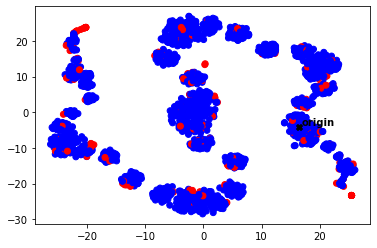

Original claims:
 1. An image display device comprising: scanning lines arranged in rows; signal lines arranged in columns; a scanner part configured to supply a control signal to the scanning lines; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal of the drive transistor, and a channel length of the drive transi

In [268]:
# zs0 = zs[np.where(ys==0)[0]]
# zs1 = zs[np.where(ys==1)[0]]
# near_mean_idx1 = np.argsort(np.sum(abs(zs0 - np.mean(zs0, axis=0)), axis=1))[:1000]
# near_mean_idx2 = np.argsort(np.sum(abs(zs1 - np.mean(zs1, axis=0)), axis=1))[:100]
# near_mean_idx_ = np.concatenate([near_mean_idx1, near_mean_idx2])

near_mean_idx = np.argsort(np.sum(abs(zs - np.mean(zs, axis=0)), axis=1))[:2500]
# near_mean_idx_ = near_mean_idx
near_mean_idx_ = np.union1d(near_mean_idx, np.random.choice(np.where(ys==1)[0], 50))
enc_outputs = final_model.module.encode(input_inf)
org_z = copy.deepcopy(enc_outputs.view(1,-1).cpu().detach().numpy())
pred_outputs = predictor(enc_outputs)
org_y = copy.deepcopy(pred_outputs.argmax(1).cpu().detach().numpy())
dec_inputs = None

zs_for_tsne = np.concatenate([zs[near_mean_idx_], org_z])
ys_for_tsne = np.concatenate([ys[near_mean_idx_], org_y])
tsne = TSNE(early_exaggeration=10, learning_rate="auto", n_iter=500, init="random", verbose=0, metric="cosine", square_distances=True)
z_tsne = tsne.fit_transform(zs_for_tsne)
plt.scatter(z_tsne[:-1,0], z_tsne[:-1,1], c=ys_for_tsne[:-1], cmap="bwr")
plt.scatter(z_tsne[-1,0], z_tsne[-1,1], c="k", marker="X")
plt.text(z_tsne[-1,0]+0.5, z_tsne[-1,1]+0.5, "origin", weight="bold")
plt.show()

print("Original claims:\n",input_claims,"\n")

Iteration 0
Estimaed forward citations (Iter 0): 0.0714 (0.9286)
sum of gradient (Iter 0): 3.004350185394287


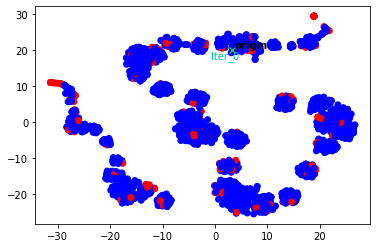

[ 3.306275 20.040693] [ 3.306064 20.039268]
Generated claims (Iter 0):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal of the 

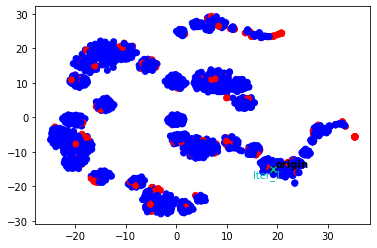

[ 19.231426 -15.008087] [ 19.228436  -15.0116825]
Generated claims (Iter 1):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel,, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal of the dri

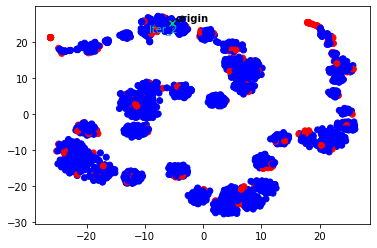

[-5.3022456 25.474442 ] [-5.2985654 25.479534 ]
Generated claims (Iter 2):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal of 

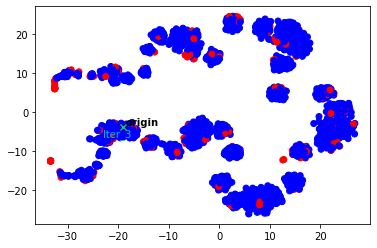

[-19.035387   -3.7600672] [-19.03028    -3.7534752]
Generated claims (Iter 3):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor connected connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control termina

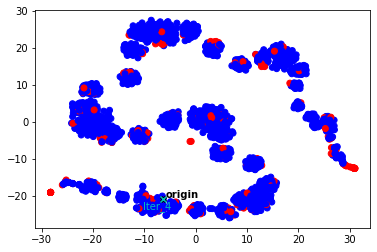

[ -6.3237824 -20.818247 ] [ -6.316349 -20.812286]
Generated claims (Iter 4):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal o

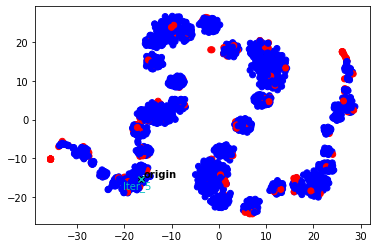

[-16.406366 -15.32565 ] [-16.390564 -15.325914]
Generated claims (Iter 5):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel and, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal of the dr

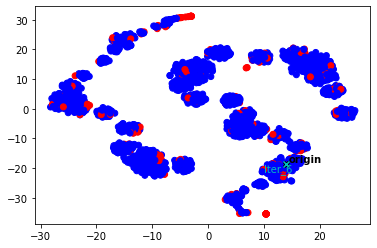

[ 13.929055 -18.631327] [ 13.934533 -18.616877]
Generated claims (Iter 6):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel in, the pixel capacitor connected between a current terminal and a control terminal of the dri

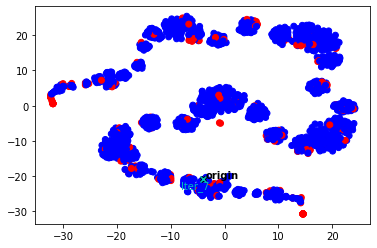

[ -4.060976 -20.951294] [ -4.064394 -20.936563]
Generated claims (Iter 7):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal of 

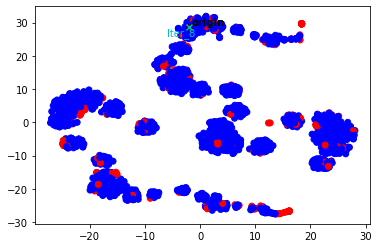

[-1.9690927 28.817104 ] [-1.9893043 28.821165 ]
Generated claims (Iter 8):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal of 

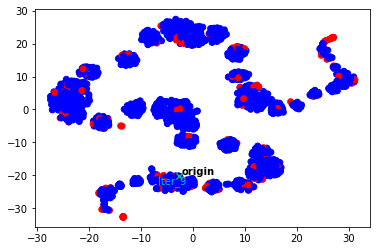

[ -2.7511396 -20.212215 ] [ -2.7400796 -20.193077 ]
Generated claims (Iter 9):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage thereof and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control termi

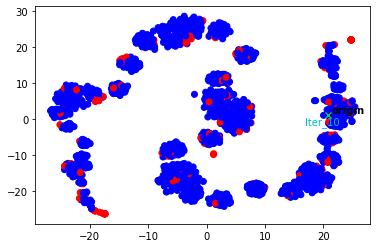

[20.871769   1.1103712] [20.85286    1.1037182]
Generated claims (Iter 10):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal of

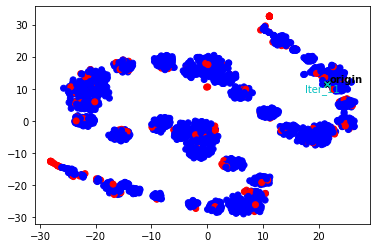

[21.514719 11.57809 ] [21.502897 11.561141]
Generated claims (Iter 11):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel,, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal of the drive tr

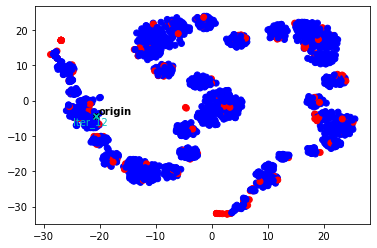

[-20.749725  -4.217208] [-20.726677   -4.2203975]
Generated claims (Iter 12):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal 

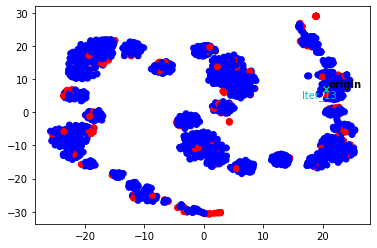

[20.590164   6.9618864] [20.569     6.944102]
Generated claims (Iter 13):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal of t

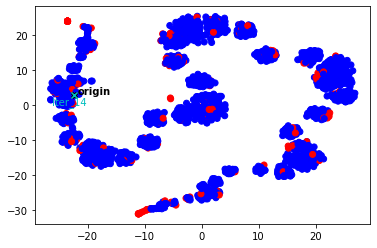

[-22.332033    2.7047915] [-22.31018     2.6902251]
Generated claims (Iter 14):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel in, the pixel capacitor connected between a current terminal and a control terminal of th

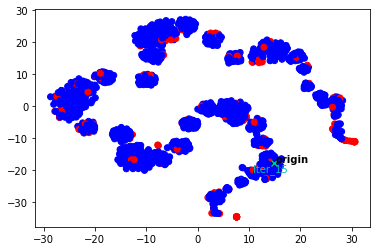

[ 14.753961 -17.884645] [ 14.7818775 -17.867012 ]
Generated claims (Iter 15):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel in, the pixel capacitor connected between a current terminal and a control terminal of the 

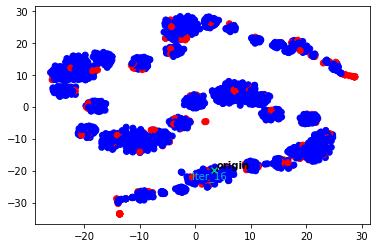

[  3.4009132 -19.830135 ] [  3.4082372 -19.80221  ]
Generated claims (Iter 16):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control termina

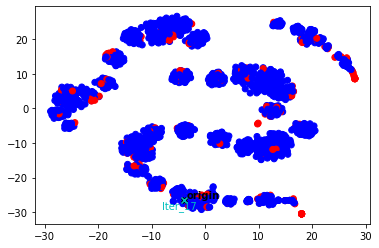

[ -3.9919648 -26.466671 ] [ -4.018858 -26.47307 ]
Generated claims (Iter 17):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal 

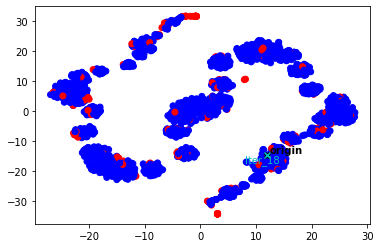

[ 11.9723625 -14.574799 ] [ 11.953442 -14.549735]
Generated claims (Iter 18):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel capacitor, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal 

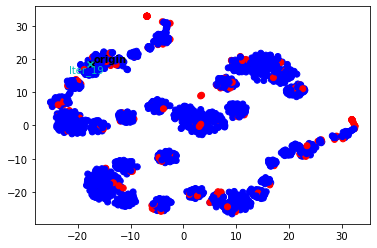

[-17.583902  18.583899] [-17.61826   18.584227]
Generated claims (Iter 19):
 1. an image display device comprising : scanning lines arranged in rows ; signal lines arranged in columns ; a scanner part configured to supply a control signal to the scanning lines ; and pixel circuits in a matrix connected to the scanning lines and the signal lines, wherein at least one of the pixel circuits includes a sampling transistor, a drive transistor, a pixel capacitor, a light emitting device, a first switching transistor directly connected between a first voltage line and the pixel directly, a second switching transistor directly connected between a second voltage line and the light emitting device, and a third switching transistor directly connected between a third voltage line and the drive transistor, the sampling transistor is configured to supply a signal potential from the signal line to the pixel capacitor, the pixel capacitor connected between a current terminal and a control terminal of 

In [269]:
n_iter = 20
step_size = 5

for i in range(n_iter):
    print(f"Iteration {i}")
    pred_outputs = predictor(enc_outputs)
    enc_outputs.retain_grad()
#     FC_estimated = pred_outputs[0,0] # TEMPORARY - switch direction of optimization (to lower the probability of L0)
#     FC_estimated_inv = pred_outputs[0,1].item()
    FC_estimated = pred_outputs[0,1] # estimated forward citations
    FC_estimated_inv = pred_outputs[0,0].item()
    if i % 1 == 0:
        print(f"Estimaed forward citations (Iter {i}): {np.round(np.exp(FC_estimated.item()), 4)} ({np.round(np.exp(FC_estimated_inv),4)})")
    FC_estimated.backward(retain_graph=True)
        
#     grad_for_update = -(step_size * enc_outputs.grad) # TEMPORARY - switch direction of optimization (to lower the probability of L0)
    grad_for_update = (step_size * enc_outputs.grad)
    if i % 1 == 0:
        print(f"sum of gradient (Iter {i}): {grad_for_update.sum()}")
    enc_outputs_ = enc_outputs + grad_for_update
    
    curr_z = copy.deepcopy(enc_outputs_.view(1,-1).cpu().detach().numpy())
    curr_y = copy.deepcopy(pred_outputs.argmax(1).cpu().detach().numpy())
    
    zs_for_tsne = np.concatenate([zs[near_mean_idx_], org_z, curr_z])
    ys_for_tsne = np.concatenate([ys[near_mean_idx_], org_y, curr_y])
    
#     tsne = TSNE(early_exaggeration=20, learning_rate="auto", n_iter=500, init="random", verbose=0, metric="cosine")
    z_tsne = tsne.fit_transform(zs_for_tsne)
    plt.scatter(z_tsne[:-1,0], z_tsne[:-1,1], c=ys_for_tsne[:-1], cmap="bwr")
    plt.scatter(z_tsne[-2,0], z_tsne[-2,1], c="k", marker="X")
    plt.text(z_tsne[-2,0]+0.5, z_tsne[-2,1]+0.5, "origin", weight="bold")
    plt.scatter(z_tsne[-1,0], z_tsne[-1,1], c="c", marker="x")
    plt.text(z_tsne[-1,0]-4, z_tsne[-1,1]-2.5, f"Iter_{i}", c="c")
    plt.show()
    
    enc_outputs.grad.zero_()
    dec_outputs = final_model.module.decode(input_inf, enc_outputs_, dec_inputs=dec_inputs)[:, 1:]
    # convert shape if dec_inputs are specified
    if dec_inputs is not None:
        dec_outputs = dec_outputs.argmax(-1)
    generated_claims = final_model.module.tokenizer.decode_batch(dec_outputs.cpu().detach().numpy(), skip_special_tokens=False)[0].split("<EOS>")[0]
    if i % 1 == 0:
        print(f"Generated claims (Iter {i}):\n", generated_claims,"\n")
    
    enc_outputs = enc_outputs_